In [1]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

We will generate fake data, that will simulate dataset of 100 outputs from 200 dimensional linear model along with appropriate predictors. Our goal will be estimation of the parameters of the model.

In [2]:
data_genetator = CmdStanModel(stan_file = 'generate_data.stan')

INFO:cmdstanpy:compiling stan file /Users/patryktomaszewski/studies/master deegre sem 1/data analitycs/Data-Analytics-labs/Lab 4 - Linear models/generate_data.stan to exe file /Users/patryktomaszewski/studies/master deegre sem 1/data analitycs/Data-Analytics-labs/Lab 4 - Linear models/generate_data
INFO:cmdstanpy:compiled model executable: /Users/patryktomaszewski/studies/master deegre sem 1/data analitycs/Data-Analytics-labs/Lab 4 - Linear models/generate_data


In [5]:
I = len("patryk")  #number of letters in name
N = len("tomaszewski")  #number of letters in surname
DoB= 300999#date of birth
seed=int(DoB*1e4+100*I+N)
print(seed)
generated_data = data_genetator.sample(chains=1, iter_sampling=1, iter_warmup=0, fixed_param=True,seed=seed)

3009990611


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


### Coefficients of linear model
Only few of beta coefficients are significantly greater than 0.

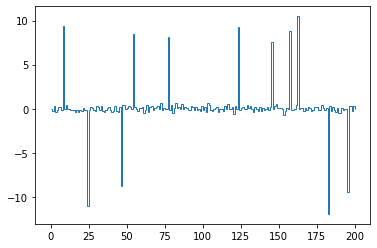

In [6]:
beta_s = generated_data.stan_variable('beta')
plt.stairs(generated_data.stan_variable('beta')[0])

This is an issue called sparsity. We will try to exploit that when infering the results via changing the prior structure. 

### Model 1 - uniform prior for beta

In [7]:
model_uniform = CmdStanModel(stan_file = 'model1.stan')

INFO:cmdstanpy:compiling stan file /Users/patryktomaszewski/studies/master deegre sem 1/data analitycs/Data-Analytics-labs/Lab 4 - Linear models/model1.stan to exe file /Users/patryktomaszewski/studies/master deegre sem 1/data analitycs/Data-Analytics-labs/Lab 4 - Linear models/model1
INFO:cmdstanpy:compiled model executable: /Users/patryktomaszewski/studies/master deegre sem 1/data analitycs/Data-Analytics-labs/Lab 4 - Linear models/model1


In [9]:
data_for_inference = {'N':100,
                      'M':200,
                      'X':generated_data.stan_variable('X')[0],
                      'y':generated_data.stan_variable('y')[0]
                      }

In [10]:
fit_unf = model_uniform.sample(data=data_for_inference,seed=seed)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [11]:
print(fit_unf.diagnose())

Processing csv files: /var/folders/4p/0qz7dp9d0z77llrj1f8zbg1w0000gn/T/tmphig4ydfs/model1-20220405224131_1.csv, /var/folders/4p/0qz7dp9d0z77llrj1f8zbg1w0000gn/T/tmphig4ydfs/model1-20220405224131_2.csv, /var/folders/4p/0qz7dp9d0z77llrj1f8zbg1w0000gn/T/tmphig4ydfs/model1-20220405224131_3.csv, /var/folders/4p/0qz7dp9d0z77llrj1f8zbg1w0000gn/T/tmphig4ydfs/model1-20220405224131_4.csv

Checking sampler transitions treedepth.
3997 of 4000 (99.92%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
3 of 4000 (0.07%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sa

#### Task 1. Evaluating model

1. Analyse the diagnosis of model. What sampling issues occured?
2. For each fitted beta coefficient plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with true values of beta. 
3. Substract true values from fitted betas and make the same plot (residues)

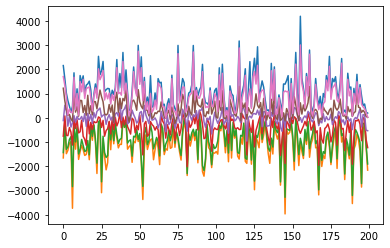

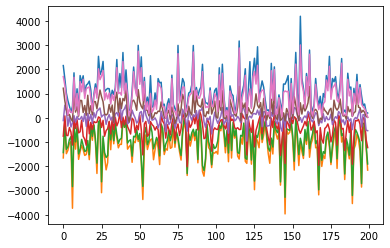

In [34]:
def plot_quantiles(beta):
    maximum = []
    minimum = []
    quantiles=[[], [], [], [], []]
    quantile_levels=[0.05, 0.25, 0.5, 0.75, 0.95]
    for elem in range(beta.shape[-1]):
        temp_arr = beta[:, elem]
        maximum.append(np.max(temp_arr))
        minimum.append(np.min(temp_arr))
        for quantile, level in zip(quantiles, quantile_levels):
            quantile.append(np.quantile(temp_arr, level))
    plt.plot(maximum)
    plt.plot(minimum)
    for q in quantiles:
        plt.plot(q)
    plt.show()
    

def plot_residuals(residuals):
    maximum = []
    minimum = []
    quantiles=[[], [], [], [], []]
    quantile_levels=[0.05, 0.25, 0.5, 0.75, 0.95]

    for elem in range(residuals.shape[-1]):
        temp_arr = residuals[:, elem]
        maximum.append(np.max(temp_arr))
        minimum.append(np.min(temp_arr))
        for quantile, level in zip(quantiles, quantile_levels):
            quantile.append(np.quantile(temp_arr, level))
    plt.plot(maximum)
    plt.plot(minimum)
    for q in quantiles:
        plt.plot(q)
    plt.show()
    
    
beta = fit_unf.stan_variable(var='beta')
plot_quantiles(beta)
    
residuals = fit_unf.stan_variable(var='beta') - data_for_inference['X'][:,0]
plot_residuals(residuals)

### Model 2 - Narrow weakly informative prior.
We try to improve sampling by regularizing the search space with normal priors. This is prior used in ridge regression (but here is the bayesian context)

In [15]:
model_reg = CmdStanModel(stan_file = 'model2.stan')

INFO:cmdstanpy:compiling stan file /Users/patryktomaszewski/studies/master deegre sem 1/data analitycs/Data-Analytics-labs/Lab 4 - Linear models/model2.stan to exe file /Users/patryktomaszewski/studies/master deegre sem 1/data analitycs/Data-Analytics-labs/Lab 4 - Linear models/model2
INFO:cmdstanpy:compiled model executable: /Users/patryktomaszewski/studies/master deegre sem 1/data analitycs/Data-Analytics-labs/Lab 4 - Linear models/model2


In [16]:
fit_reg = model_reg.sample(data=data_for_inference,seed=seed)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [17]:
print(fit_reg.diagnose())

Processing csv files: /var/folders/4p/0qz7dp9d0z77llrj1f8zbg1w0000gn/T/tmphig4ydfs/model2-20220405225511_1.csv, /var/folders/4p/0qz7dp9d0z77llrj1f8zbg1w0000gn/T/tmphig4ydfs/model2-20220405225511_2.csv, /var/folders/4p/0qz7dp9d0z77llrj1f8zbg1w0000gn/T/tmphig4ydfs/model2-20220405225511_3.csv, /var/folders/4p/0qz7dp9d0z77llrj1f8zbg1w0000gn/T/tmphig4ydfs/model2-20220405225511_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



#### Task 2. Evaluating model

1. Analyse the diagnosis of model. Are the sampling problems solved
2. For each fitted beta coefficient plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with true values of beta. 
3. Substract true values from fitted betas and make the same plot (residues)

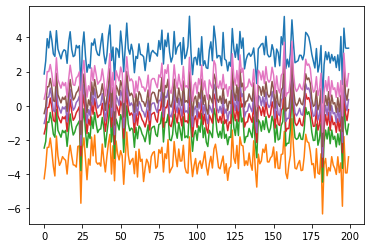

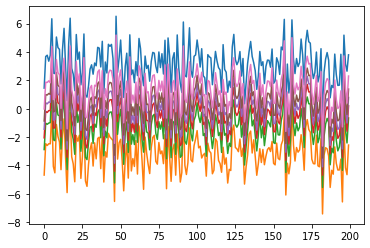

In [37]:
beta = fit_reg.stan_variable(var='beta')
plot_quantiles(beta) 

residuals = beta - data_for_inference['X'][:,0]
plot_residuals(residuals)

### Model 3 -  Sparsity enforcing prior

We will now try to enforce shrinking of small parameters using a Laplace prior. This is a prior that is used in Lasso regression. (but here is the bayesian context)

In [38]:
model_lap = CmdStanModel(stan_file = 'model3.stan')

INFO:cmdstanpy:compiling stan file /Users/patryktomaszewski/studies/master deegre sem 1/data analitycs/Data-Analytics-labs/Lab 4 - Linear models/model3.stan to exe file /Users/patryktomaszewski/studies/master deegre sem 1/data analitycs/Data-Analytics-labs/Lab 4 - Linear models/model3
INFO:cmdstanpy:compiled model executable: /Users/patryktomaszewski/studies/master deegre sem 1/data analitycs/Data-Analytics-labs/Lab 4 - Linear models/model3


In [39]:
fit_lap = model_lap.sample(data=data_for_inference,seed=seed,adapt_delta=0.99,max_treedepth=12) #sampling problematic some parameters have to be adjusted

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [40]:
print(fit_lap.diagnose())

Processing csv files: /var/folders/4p/0qz7dp9d0z77llrj1f8zbg1w0000gn/T/tmphig4ydfs/model3-20220405230321_1.csv, /var/folders/4p/0qz7dp9d0z77llrj1f8zbg1w0000gn/T/tmphig4ydfs/model3-20220405230321_2.csv, /var/folders/4p/0qz7dp9d0z77llrj1f8zbg1w0000gn/T/tmphig4ydfs/model3-20220405230321_3.csv, /var/folders/4p/0qz7dp9d0z77llrj1f8zbg1w0000gn/T/tmphig4ydfs/model3-20220405230321_4.csv

Checking sampler transitions treedepth.
1000 of 4000 (25.00%) transitions hit the maximum treedepth limit of 12, or 2^12 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
1 of 4000 (0.03%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sa

#### Task 3. Evaluating model

1. Analyse the diagnosis of model. Are the sampling problems solved. Are there any new sampling issues?
2. For each fitted beta coefficient plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with true values of beta. 
3. Substract true values from fitted betas and make the same plot (residues)

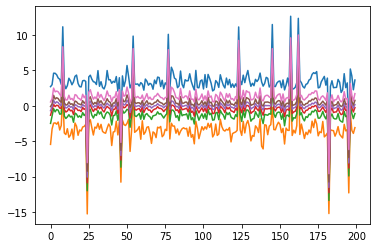

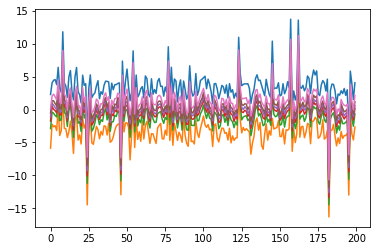

In [41]:
beta = fit_lap.stan_variable(var='beta')
plot_quantiles(beta) 

residuals = beta - data_for_inference['X'][:,0]
plot_residuals(residuals)